In [51]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from itertools import combinations
from collections import Counter

sns.set_theme(style="whitegrid")

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from itertools import combinations
from collections import Counter


class Analyzer:
    def __init__(self, source_file):
        self.source_file = source_file
        self.df = None
        self._load_data()
        self.tags = set()
        self.df["date"] = pd.to_datetime(
            self.df["CreateDateString"], format="%d.%m.%Y", errors="coerce"
        )

    # DF Analysis
    def _load_data(self):
        """Load the JSONL metadata file into a DataFrame."""
        try:
            self.df = pd.read_json(self.source_file, lines=True)
            self.df["date"] = pd.to_datetime(
                self.df["CreateDateString"], format="%d.%m.%Y"
            )

            print(f"✅ Loaded {len(self.df)} records from {self.source_file}")
        except Exception as e:
            print(f"❌ Failed to load data: {e}")
            self.df = pd.DataFrame()  # Empty fallback

    def view_df(self, n=5):
        """Print the first n rows of the DataFrame."""
        print(self.df.head(n))

    def info(self):
        """Print summary info (columns, types, non-nulls, etc)."""
        print(self.df.info())

    def shape(self):
        """Return DataFrame shape (rows, columns)."""
        print(self.df.shape)

    def show_columns(self):
        """Print the columns in the DataFrame."""
        print(self.df.columns.tolist())

    def preview_random(self, n=5):
        """Show a random sample of rows."""
        print(self.df.sample(n))

    def describe_dates(self, date_col="CreateDateString"):
        """Print the min/max date (if available)."""
        if date_col in self.df.columns:
            print("Earliest date:", self.df[date_col].min())
            print("Latest date:", self.df[date_col].max())
        else:
            print(f"No '{date_col}' column found.")

    def missing_report(self):
        """Show count of missing values per column."""
        print(self.df.isnull().sum())

    def display_col(self, col):
        for value in self.df[col]:
            print(value)

    # Tag Analysis
    def get_tag_counts(self, col="Tags"):
        tag_counter = Counter()
        for tag_list in self.df[col]:
            if isinstance(tag_list, list):
                for tag in tag_list:
                    if tag:  # skip empty
                        tag_counter.update([tag])
            elif isinstance(tag_list, str):
                # Assume tags in string are comma-separated, or just one tag
                tags = [
                    tag.strip().lower() for tag in tag_list.split(",") if tag.strip()
                ]
                tag_counter.update(tags)
            # Else: skip (could be None, float, etc.)
        return tag_counter

    def plot_tag_counts(self, col="Tags", top_n=20):
        tag_counter = self.get_tag_counts(col)
        if not tag_counter:
            print("No tags found.")
            return

        common_tags = tag_counter.most_common(top_n)
        tags, counts = zip(*common_tags)
        plt.figure(figsize=(10, max(4, int(top_n * 0.5))),dpi=200)
        sns.set_theme(style="whitegrid")
        ax = sns.barplot(
            y=list(tags), x=list(counts), palette="crest", hue=list(counts)
        )

        ax.set_title(f"Top {top_n} Tags", fontsize=16)
        ax.set_xlabel("Count", fontsize=13)
        ax.set_ylabel("Tag", fontsize=13)
        plt.tight_layout()
        plt.show()

    # Date Analysis
    def articles_per_day(self, print_bool=False):
        counts = self.df["date"].value_counts().sort_index()
        # print(counts)
        if print_bool:
            print(counts)
        return counts

    def articles_per_week(self):
        # Group by year-week
        weekly = self.df.groupby(self.df["date"].dt.isocalendar().week)["Id"].count()
        print(weekly)
        return weekly

    def articles_per_month(self):
        monthly = self.df.groupby(self.df["date"].dt.to_period("M"))["Id"].count()
        print(monthly)
        return monthly

    def longest_shortest_day(self):
        counts = self.articles_per_day()
        max_count = counts.max()
        min_count = counts.min()
        busiest = counts[counts == max_count]
        slowest = counts[counts == min_count]
        busiest_single = busiest.index[0]
        slowest_single = slowest.index[0]
        print(f"Most articles: {max_count} on {busiest_single}")
        print(f"Fewest articles: {min_count} on {slowest_single}")
        return busiest, slowest

    def articles_per_month_around_date(
        self, selected_date, months_window=3, date_col="date"
    ):
        """
        Plots monthly article counts centered around selected_date ± months_window.
        """
        if not isinstance(selected_date, pd.Timestamp):
            selected_date = pd.to_datetime(selected_date)
        start = selected_date - pd.DateOffset(months=months_window)
        end = selected_date + pd.DateOffset(months=months_window)
        mask = (self.df[date_col] >= start) & (self.df[date_col] <= end)
        df_window = self.df[mask]
        # Group by month
        monthly = df_window.groupby(df_window[date_col].dt.to_period("M"))["Id"].count()
        monthly = monthly.reset_index()
        monthly[date_col] = monthly[date_col].astype(str)

        plt.figure(figsize=(10, 4),dpi=200)
        sns.set_theme(style="whitegrid")
        ax = sns.barplot(
            x=date_col, y="Id", data=monthly, palette="crest", hue=date_col
        )
        ax.set_title(
            f"Articles per Month Around {selected_date.strftime('%Y-%m-%d')}",
            fontsize=16,
        )
        ax.set_xlabel("Month", fontsize=13)
        ax.set_ylabel("Article Count", fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        return monthly

    def plot_trend(self, freq="D"):
        # freq: "D"=daily, "W"=weekly, "M"=monthly
        if freq == "D":
            counts = self.articles_per_day()
        elif freq == "W":
            counts = self.articles_per_week()
        else:
            counts = self.articles_per_month()

        # Convert to DataFrame for easier plotting if needed
        counts = counts.reset_index()
        df = pd.DataFrame(data=counts)
        df.columns = ["Date", "Article_Count"]
        print(df.dtypes)
        plt.figure(figsize=(12, 5),dpi=200)
        sns.set_theme(style="whitegrid")
        # Always convert Period to string for plotting
        if pd.api.types.is_period_dtype(df["Date"]):
            df["Date"] = df["Date"].astype(str)

        ax = sns.lineplot(
            data=df,
            x="Date",
            y="Article_Count",
            marker="o",
            linewidth=2,
            color="#1976D2",
        )
        peak_idx = df["Article_Count"].idxmax()
        peak_x = df.loc[peak_idx, "Date"]
        peak_y = df.loc[peak_idx, "Article_Count"]
        ax.scatter([peak_x], [peak_y], color="red", s=100, zorder=5, label="Peak")
        ax.annotate(
            f"Peak: {peak_y}",
            xy=(peak_x, peak_y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            color="red",
            fontsize=12,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7),
        )

        ax.set_title(f"Article Frequency Trend ({freq})", fontsize=17)
        ax.set_xlabel("Date", fontsize=13)
        ax.set_ylabel("Number of Articles", fontsize=13)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
        plt.xticks(rotation=45, ha="right")
        ax.legend(loc="upper left")
        ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_tag_coverage_over_time(
        self, tag, date_col="date", tags_col="Tags", top_n_months=None, color="#009688"
    ):
        """
        Plots the number of articles per month containing the specified tag.
        """
        tag_lower = tag.lower()
        mask = self.df[tags_col].apply(
            lambda tags: tag_lower in [str(t).lower() for t in tags]
            if isinstance(tags, list)
            else tag_lower in str(tags).lower()
        )
        tag_df = self.df[mask]
        if tag_df.empty:
            print(f'No articles found with tag "{tag}"')
            return
        monthly_counts = tag_df.groupby(tag_df[date_col].dt.to_period("M"))[
            "Id"
        ].count()
        if top_n_months:
            monthly_counts = (
                monthly_counts.sort_values(ascending=False)
                .head(top_n_months)
                .sort_index()
            )
        df_plot = monthly_counts.reset_index()
        df_plot.columns = ["Month", "Article_Count"]
        df_plot["Month"] = df_plot["Month"].astype(str)

        plt.figure(figsize=(12, 5),dpi=200)
        sns.set_theme(style="whitegrid")
        ax = sns.barplot(x="Month", y="Article_Count", data=df_plot, color=color)

        # Highlight the peak month
        peak_idx = df_plot["Article_Count"].idxmax()
        ax.bar(
            peak_idx,
            df_plot.loc[peak_idx, "Article_Count"],
            color="red",
            alpha=0.7,
            label="Peak Month",
        )

        ax.set_title(f'Coverage of "{tag}" Over Time', fontsize=16)
        ax.set_xlabel("Month", fontsize=13)
        ax.set_ylabel("Number of Articles", fontsize=13)
        plt.xticks(rotation=45, ha="right")
        ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
        ax.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        return monthly_counts

    def tag_cooccurrence_matrix(
        self, tag_col="Tags", top_n=20, plot_heatmap=True, annot=None, cmap="crest"
    ):
        """
        Build and (optionally) plot a tag co-occurrence matrix.
        """
        co_counter = Counter()
        tag_freq = Counter()
        for taglist in self.df[tag_col].dropna():
            unique_tags = list(set(taglist))  # avoid dups
            tag_freq.update(unique_tags)
            for tag_pair in combinations(sorted(unique_tags), 2):
                co_counter[tag_pair] += 1

        top_tags = [tag for tag, _ in tag_freq.most_common(top_n)]
        matrix = pd.DataFrame(0, index=top_tags, columns=top_tags, dtype=int)
        for (tag1, tag2), count in co_counter.items():
            if tag1 in top_tags and tag2 in top_tags:
                matrix.loc[tag1, tag2] = count
                matrix.loc[tag2, tag1] = count

        if plot_heatmap:
            plt.figure(figsize=(1.2 + 0.45 * top_n, 1.2 + 0.45 * top_n),dpi=200)
            # Auto-annotate only for small matrices, else use passed param
            show_annot = annot if annot is not None else top_n <= 15
            ax = sns.heatmap(
                matrix,
                annot=show_annot,
                fmt="d",
                cmap=cmap,
                linewidths=0.5,
                square=True,
                cbar_kws={"shrink": 0.8, "label": "Co-occurrence Count"},
            )
            ax.set_title(
                f"Tag Co-occurrence Heatmap (Top {top_n} Tags)",
                fontsize=16,
                fontweight="bold",
            )
            ax.set_xlabel("Tag", fontsize=13)
            ax.set_ylabel("Tag", fontsize=13)
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

        return matrix

    def get_tag_month_matrix(self, tag_col="Tags", date_col="date", top_n=10):
        """
        Returns a DataFrame: rows=month, cols=top N tags, values=article counts.
        """
        # Flatten: for each article and tag, record (month, tag)
        rows = []
        for idx, row in self.df.iterrows():
            # if pd.isna(row[tag_col]) or not row[tag_col]:
            #     continue
            month = pd.to_datetime(row[date_col]).to_period("M")
            for tag in set(row[tag_col]):  # dedupe just in case
                rows.append({"month": month, "tag": tag})

        tag_month_df = pd.DataFrame(rows)
        # Count occurrences per (month, tag)
        tag_month_counts = (
            tag_month_df.groupby(["month", "tag"]).size().reset_index(name="count")
        )
        # Get top N tags overall
        top_tags = (
            tag_month_counts.groupby("tag")["count"]
            .sum()
            .sort_values(ascending=False)
            .head(top_n)
            .index.tolist()
        )
        tag_month_counts = tag_month_counts[tag_month_counts["tag"].isin(top_tags)]
        # Pivot to month × tag table
        matrix = (
            tag_month_counts.pivot(index="month", columns="tag", values="count")
            .fillna(0)
            .astype(int)
        )
        # Sort by time
        matrix = matrix.sort_index()
        return matrix

    @staticmethod
    def plot_tag_temporal_shifts(matrix, color_palette="tab20"):
        """
        Plot a stacked area chart for tag frequency over time (each column is a tag, rows are periods).
        """
        plt.figure(figsize=(14, 7),dpi=200)
        # Get colors from seaborn palette
        n_tags = len(matrix.columns)
        palette = sns.color_palette(color_palette, n_tags)
        # Use pandas .plot.area for stacked area, but use Seaborn colors
        ax = matrix.plot.area(ax=plt.gca(), alpha=0.85, color=palette, linewidth=1.5)

        plt.title("Temporal Topic Shifts (Top Tags)", fontsize=18, fontweight="bold")
        ax.set_xlabel("Month", fontsize=14)
        ax.set_ylabel("Article Count", fontsize=14)
        plt.legend(
            title="Tag",
            bbox_to_anchor=(1.01, 1),
            loc="upper left",
            fontsize=11,
            title_fontsize=12,
        )
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    def topic_emergence_decay(
        self, tag_col="Tags", date_col="date", freq="M", min_window_count=3
    ):
        """
        Identify emerging and disappearing tags per time window (e.g., month).

        Args:
            df: DataFrame
            tag_col: name of the column with tag lists
            date_col: date column (must be datetime)
            freq: window size ("M" for month, "W" for week, etc.)
            min_window_count: only consider tags appearing at least this many times in a window

        Returns:
            emergence_df: DataFrame with window, emergent_tags, decayed_tags
        """
        # 1. Assign window
        df = self.df.copy()
        df["window"] = pd.to_datetime(df[date_col]).dt.to_period(freq)

        # 2. Get tags per window
        window_tags = {}
        for window, group in df.groupby("window"):
            tags = []
            for taglist in group[tag_col]:
                if isinstance(taglist, list):
                    tags += taglist
            tag_counts = pd.Series(tags).value_counts()
            tags_set = set(tag_counts[tag_counts >= min_window_count].index)
            window_tags[window] = tags_set

        # 3. Compare window to previous/next
        windows = sorted(window_tags)
        results = []
        for i, win in enumerate(windows):
            current_tags = window_tags[win]
            prev_tags = window_tags[windows[i - 1]] if i > 0 else set()
            next_tags = window_tags[windows[i + 1]] if i < len(windows) - 1 else set()
            emergent = current_tags - prev_tags
            decayed = current_tags - next_tags  # Tags present now, gone next window
            results.append(
                {
                    "window": win,
                    "emergent_tags": sorted(list(emergent)),
                    "decayed_tags": sorted(list(decayed)),
                    "n_emergent": len(emergent),
                    "n_decayed": len(decayed),
                }
            )
        emergence_df = pd.DataFrame(results)
        return emergence_df

    @staticmethod
    def plot_topic_emergence_decay(emergence_df, window_col="window"):
        """
        Plot number of emergent and decayed tags per window.
        Optionally, annotate the most prominent tags.
        """
        plt.figure(figsize=(12, 6),dpi=200)
        x = emergence_df[window_col].astype(str)
        plt.plot(x, emergence_df["n_emergent"], label="Emergent tags", marker="o")
        plt.plot(x, emergence_df["n_decayed"], label="Decayed tags", marker="x")
        plt.title("Topic Emergence and Decay Over Time")
        plt.xlabel("Time Window")
        plt.ylabel("Number of Tags")
        plt.legend()
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        # Optional: print/annotate top emergent/decayed tags for recent windows
        print("\nRecent Emergent and Decayed Tags:")
        display_df = emergence_df[["window", "emergent_tags", "decayed_tags"]].tail(6)
        print(display_df.to_string(index=False))

    def plot_article_velocity_agg(
        self,
        tag,
        tag_col="Tags",
        date_col="date",
        freq="M",
        agg="mean",
        time_unit="days",
        color="teal",
    ):
        """
        Plot aggregate article velocity for a tag per time window (week or month).
        freq: "W" for week, "M" for month, etc.
        agg: "mean" or "max" velocity per window.
        time_unit: "days", "hours", or "minutes".
        """
        tag_lower = tag.lower()
        mask = self.df[tag_col].apply(
            lambda tags: tag_lower in [str(t).lower() for t in tags]
            if isinstance(tags, list)
            else False
        )
        tag_dates = self.df.loc[mask, date_col]
        if tag_dates.empty:
            print(f"No articles found for tag '{tag}'.")
            return

        dates_sorted = pd.to_datetime(tag_dates).sort_values()
        deltas = dates_sorted.diff().dropna()
        if time_unit == "days":
            delta_vals = deltas.dt.total_seconds() / 86400
            unit_str = "Days"
        elif time_unit == "hours":
            delta_vals = deltas.dt.total_seconds() / 3600
            unit_str = "Hours"
        else:
            delta_vals = deltas.dt.total_seconds() / 60
            unit_str = "Minutes"

        velocity = 1 / delta_vals.replace(0, float("nan"))
        vel_df = pd.DataFrame({"date": dates_sorted.iloc[1:], "velocity": velocity})
        vel_df["window"] = vel_df["date"].dt.to_period(freq)

        # Aggregate by window
        if agg == "mean":
            agg_vel = vel_df.groupby("window")["velocity"].mean()
        elif agg == "max":
            agg_vel = vel_df.groupby("window")["velocity"].max()
        else:
            raise ValueError("agg must be 'mean' or 'max'")

        df_plot = agg_vel.reset_index()
        df_plot.columns = ["Time_Window", "Velocity"]
        df_plot["Time_Window"] = df_plot["Time_Window"].astype(str)

        plt.figure(figsize=(11, 5),dpi=200)
        sns.set_theme(style="whitegrid")
        ax = sns.lineplot(
            data=df_plot,
            x="Time_Window",
            y="Velocity",
            marker="o",
            linewidth=2,
            color=color,
        )

        # Highlight the peak velocity
        peak_idx = df_plot["Velocity"].idxmax()
        peak_x = df_plot.loc[peak_idx, "Time_Window"]
        peak_y = df_plot.loc[peak_idx, "Velocity"]

        ax.scatter(
            [peak_x],
            [peak_y],
            color=color,
            s=100,
            zorder=5,
            label="Peak Velocity",
        )
        ax.annotate(
            f"Peak: {peak_y:.2f}",
            xy=(peak_x, peak_y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            color="red",
            fontsize=12,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7),
        )

        ax.set_title(
            f"{agg.capitalize()} Article Velocity for '{tag}' by {freq}",
            fontsize=15,
            fontweight="bold",
        )
        ax.set_xlabel("Time Window", fontsize=13)
        ax.set_ylabel(f"Velocity (1/{unit_str})", fontsize=13)
        plt.xticks(rotation=45, ha="right")
        ax.legend(loc="upper right")
        ax.xaxis.set_major_locator(
            ticker.MaxNLocator(nbins=10)
        )  # Or adjust 10 as needed

        ax.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        print(f"{agg.capitalize()} velocity stats:\n{agg_vel.describe()}")

        return agg_vel

    def event_coverage_lifespan(
        self, tag, tag_col="tags_norm", date_col="date", freq="D"
    ):
        """
        For a given tag, find first, peak, and last article appearance, plus lifespan.
        Optionally, return/plot daily or weekly trend.
        """
        tag_lower = tag.lower()
        mask = self.df[tag_col].apply(
            lambda tags: tag_lower in [str(t).lower() for t in tags]
            if isinstance(tags, list)
            else False
        )
        event_df = self.df.loc[mask].copy()
        if event_df.empty:
            print(f"No articles found for tag '{tag}'.")
            return None

        event_df["date"] = pd.to_datetime(event_df[date_col])
        grouped = event_df.groupby(event_df["date"].dt.to_period(freq)).size()

        first_appearance = event_df["date"].min()
        last_appearance = event_df["date"].max()
        peak_window = grouped.idxmax()
        peak_count = grouped.max()
        lifespan_days = (last_appearance - first_appearance).days

        print(f"Event/tag: '{tag}'")
        print(f"First appearance: {first_appearance.strftime('%Y-%m-%d')}")
        print(f"Peak window: {peak_window} with {peak_count} articles")
        print(f"Last appearance: {last_appearance.strftime('%Y-%m-%d')}")
        print(f"Lifespan: {lifespan_days} days ({lifespan_days // 7} weeks)")
        print(f"Total articles: {len(event_df)}")

        # Optional: return for visualization
        return grouped, first_appearance, peak_window, last_appearance

    @staticmethod
    def plot_event_lifespan(
        grouped, first_appearance, peak_window, last_appearance, freq="D", tag=""
    ):
        """
        Plot the article count over time for a tag, marking first, peak, and last.
        """
        plt.figure(figsize=(12, 5),dpi=200)
        ax = grouped.plot(kind="bar", color="#1976D2", alpha=0.8)

        plt.title(
            f"Coverage Lifespan for '{tag}' ({freq})", fontsize=16, fontweight="bold"
        )
        plt.xlabel("Date", fontsize=13)
        plt.ylabel("Article Count", fontsize=13)

        # Get x positions for first, peak, last
        x_labels = list(grouped.index.astype(str))
        first_label = str(first_appearance.to_period(freq))
        last_label = str(last_appearance.to_period(freq))
        peak_label = str(peak_window)

        highlight_colors = {
            "First": "mediumseagreen",
            "Peak": "goldenrod",
            "Last": "slateblue",
        }

        for idx, label in enumerate(x_labels):
            if label == first_label:
                ax.bar(
                    idx,
                    grouped.iloc[idx],
                    color=highlight_colors["First"],
                    alpha=0.8,
                    label="First Appearance"
                    if "First Appearance" not in ax.get_legend_handles_labels()[1]
                    else "",
                    zorder=5,
                )
            if label == peak_label:
                ax.bar(
                    idx,
                    grouped.iloc[idx],
                    color=highlight_colors["Peak"],
                    alpha=0.8,
                    label="Peak Coverage"
                    if "Peak Coverage" not in ax.get_legend_handles_labels()[1]
                    else "",
                    zorder=6,
                )
            if label == last_label:
                ax.bar(
                    idx,
                    grouped.iloc[idx],
                    color=highlight_colors["Last"],
                    alpha=0.8,
                    label="Last Appearance"
                    if "Last Appearance" not in ax.get_legend_handles_labels()[1]
                    else "",
                    zorder=7,
                )

        # Remove duplicate legend labels
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper right")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


In [53]:
analyzer = Analyzer(
        source_file="../data/eda/22-7-2025_eda_filtered_preprocessed_eng.jsonl"
    )

✅ Loaded 52052 records from ../data/eda/22-7-2025_eda_filtered_preprocessed_eng.jsonl


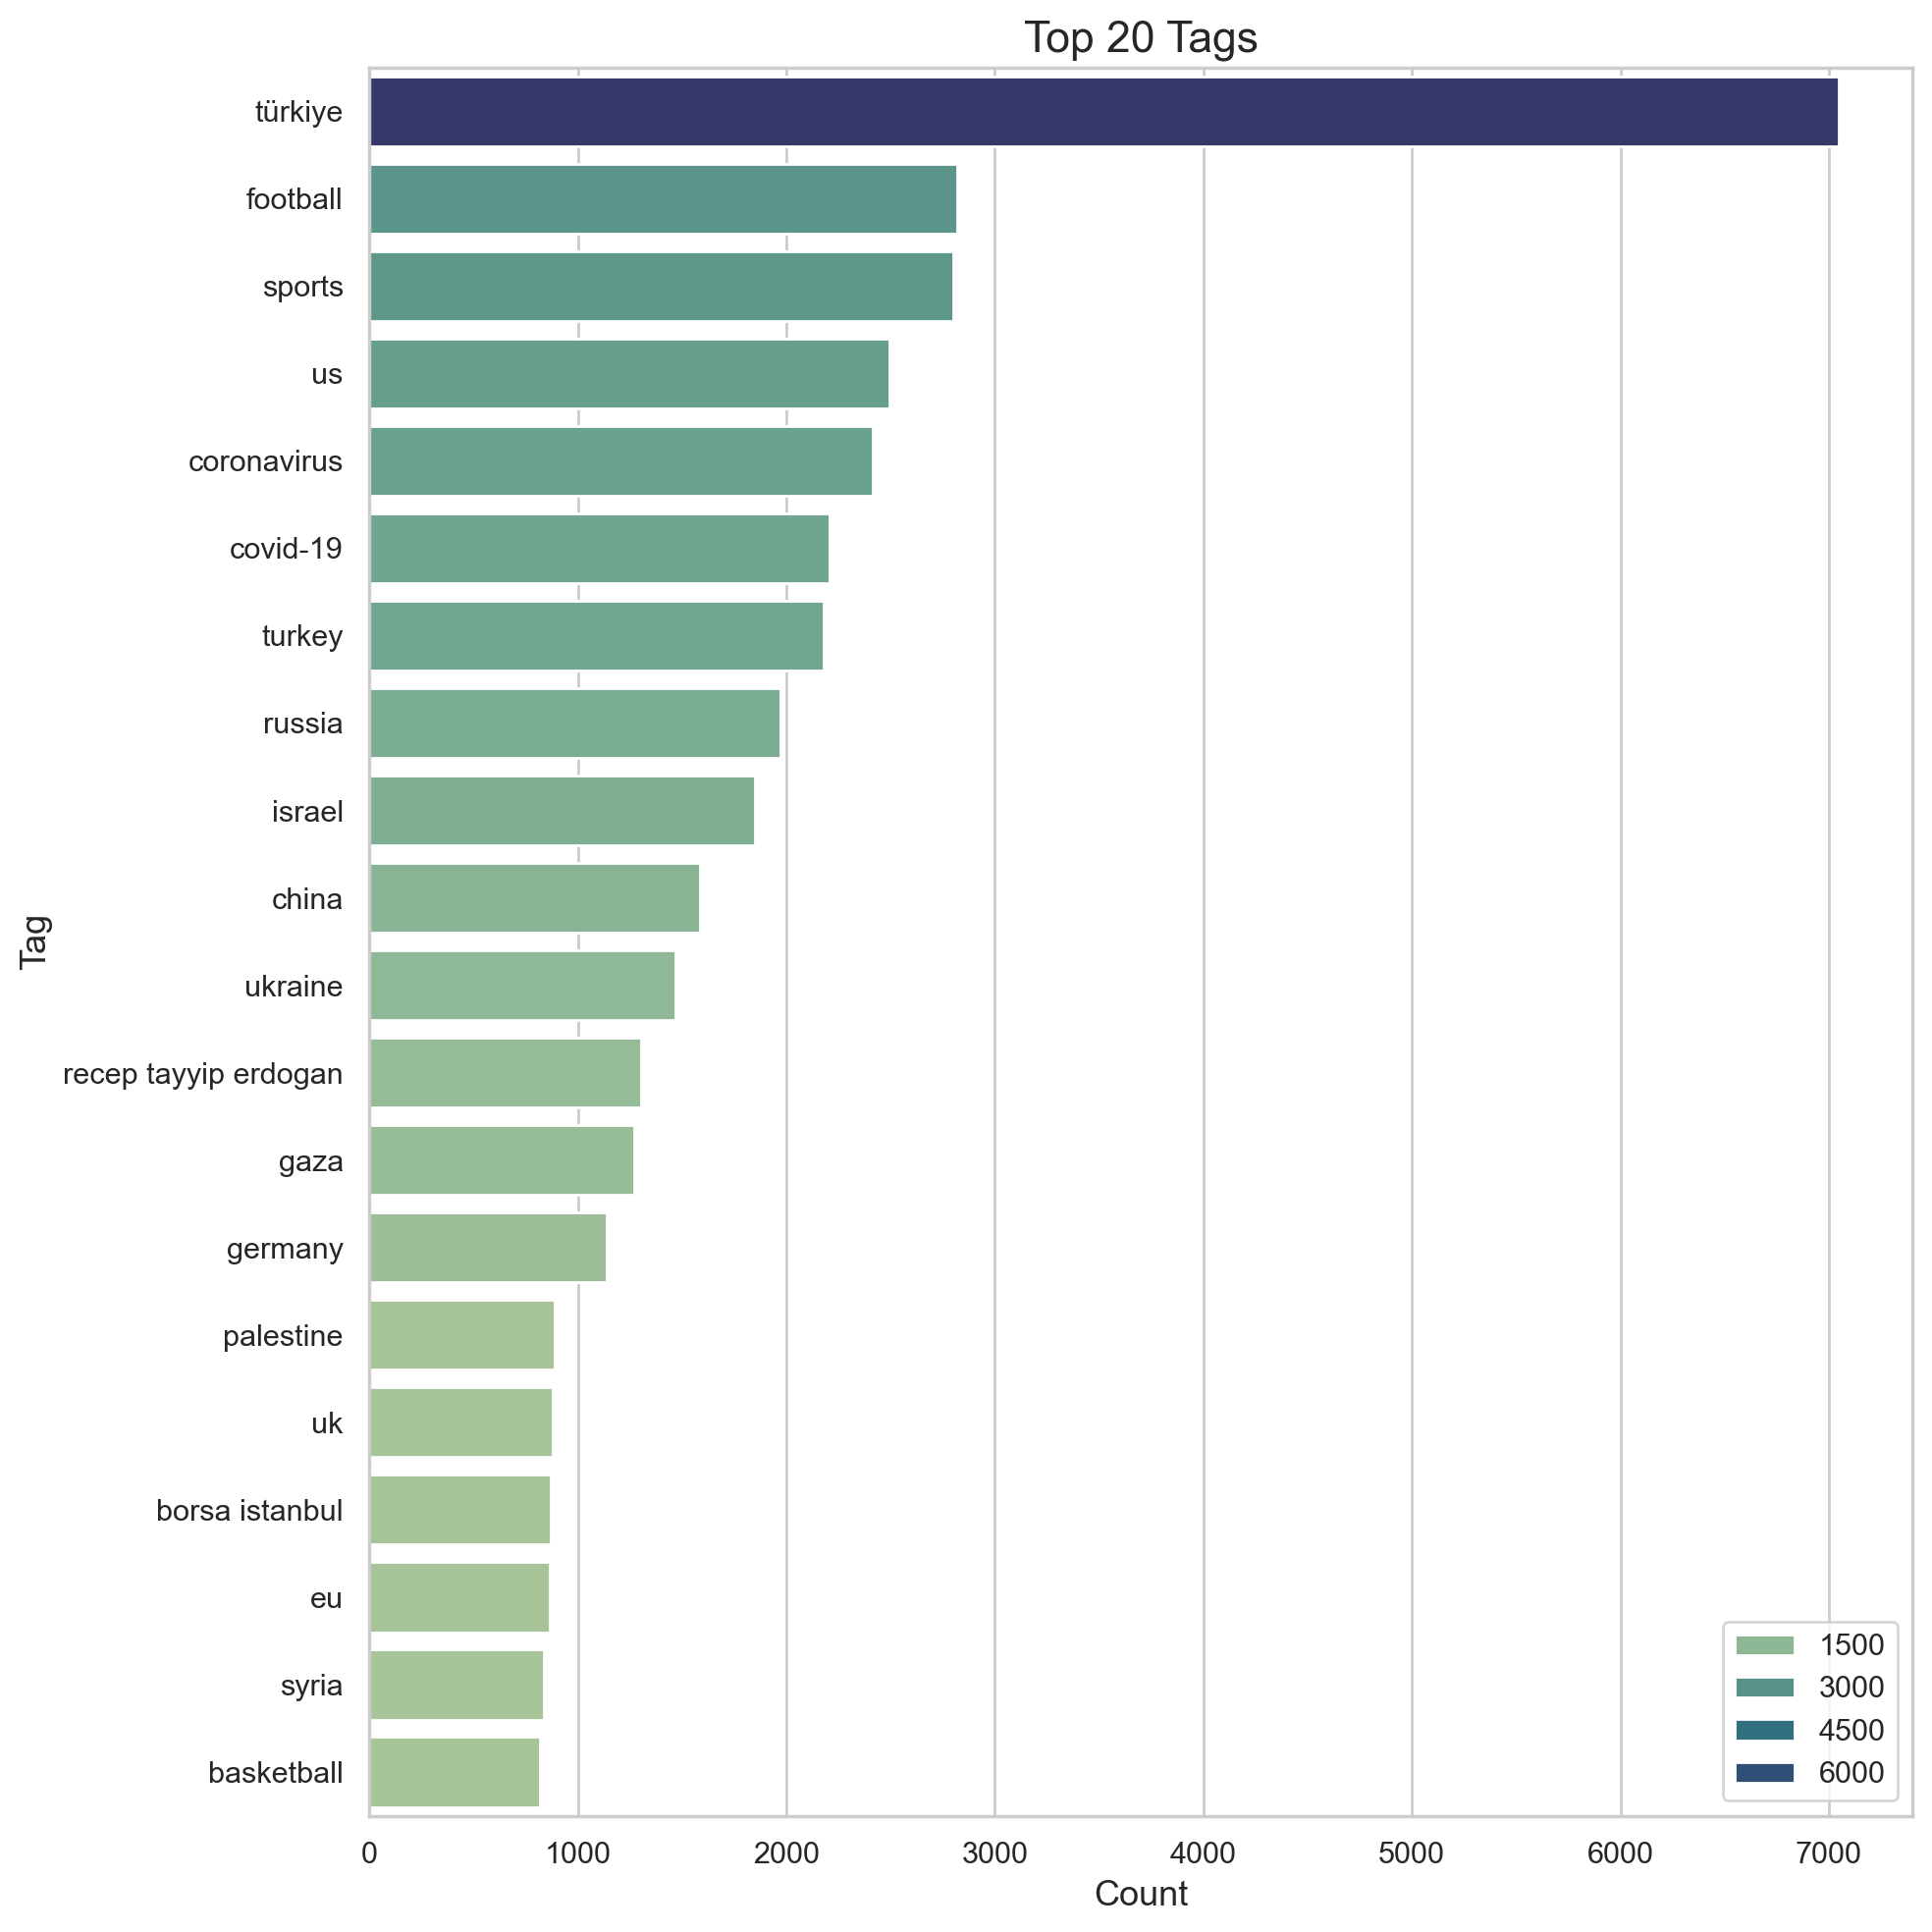

In [54]:
analyzer.plot_tag_counts(col="tags_norm")


In [55]:
analyzer.articles_per_day(print_bool=True)


date
2011-09-15     1
2011-12-01     1
2011-12-14     1
2011-12-16     1
2011-12-24     2
              ..
2025-07-17    28
2025-07-18    16
2025-07-19    17
2025-07-20    21
2025-07-21     3
Name: count, Length: 3813, dtype: int64


date
2011-09-15     1
2011-12-01     1
2011-12-14     1
2011-12-16     1
2011-12-24     2
              ..
2025-07-17    28
2025-07-18    16
2025-07-19    17
2025-07-20    21
2025-07-21     3
Name: count, Length: 3813, dtype: int64

In [56]:
analyzer.longest_shortest_day()

Most articles: 98 on 2023-02-09 00:00:00
Fewest articles: 1 on 2011-09-15 00:00:00


(date
 2023-02-09    98
 Name: count, dtype: int64,
 date
 2011-09-15    1
 2011-12-01    1
 2011-12-14    1
 2011-12-16    1
 2012-01-01    1
              ..
 2020-06-28    1
 2020-07-19    1
 2020-08-08    1
 2020-09-20    1
 2022-06-25    1
 Name: count, Length: 465, dtype: int64)

C:\Users\ozgur\AppData\Local\Temp\ipykernel_19464\1717180688.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


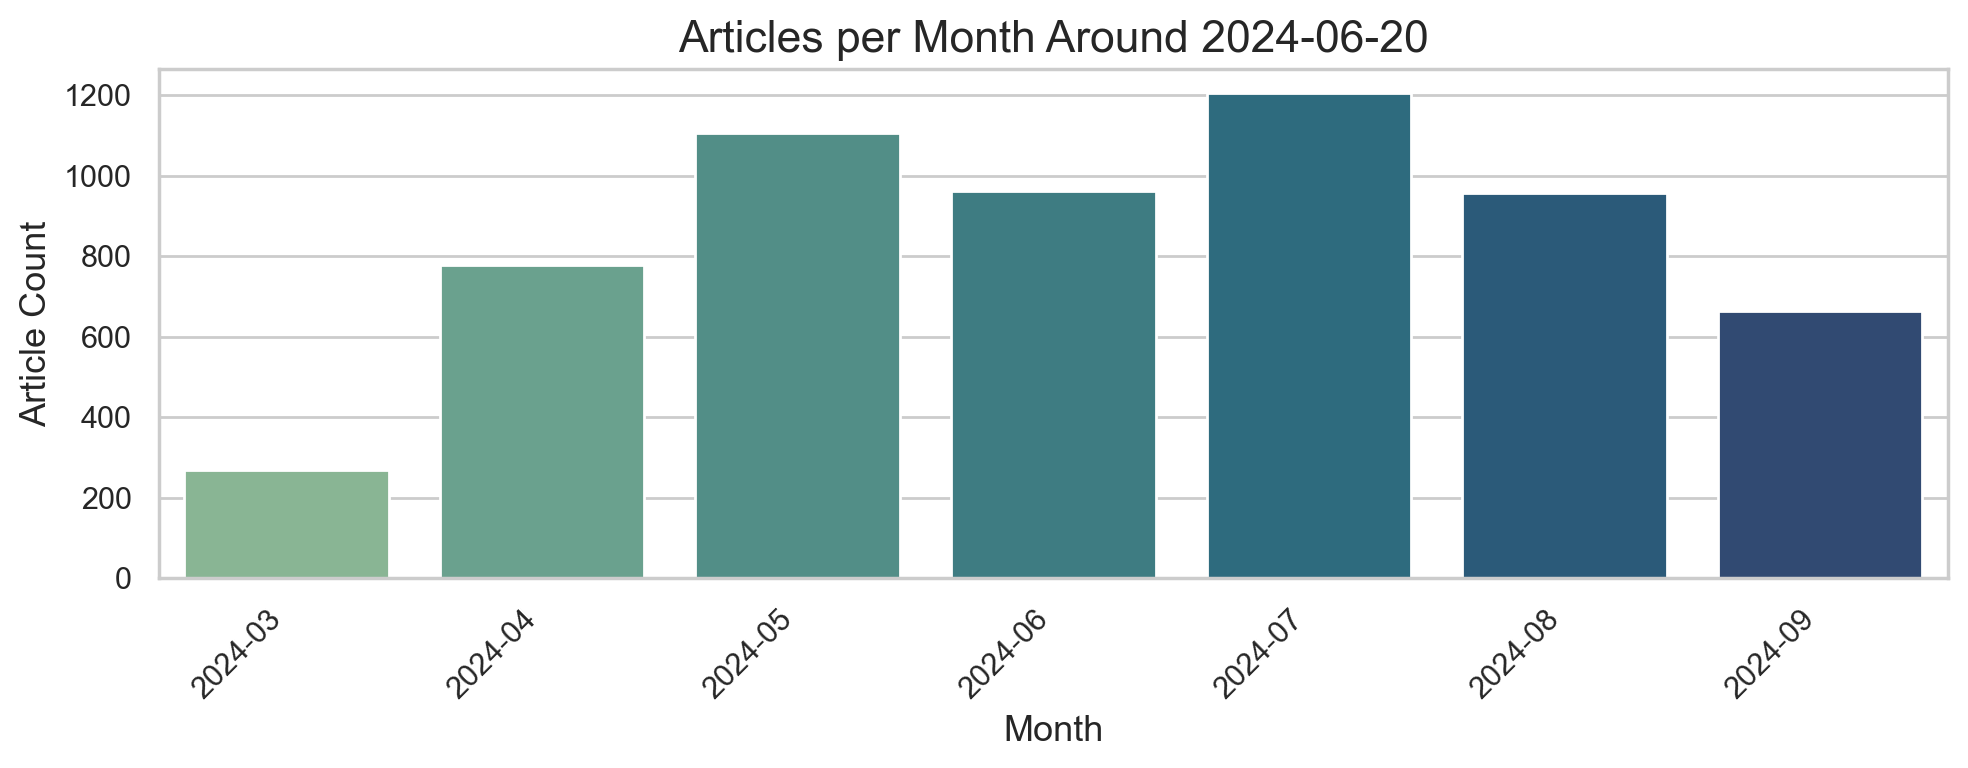

,date,Id
0,2024-03,270
1,2024-04,777
2,2024-05,1106
3,2024-06,962
4,2024-07,1205
5,2024-08,956
6,2024-09,664


In [57]:
analyzer.articles_per_month_around_date(selected_date="2024-06-20")

C:\Users\ozgur\AppData\Local\Temp\ipykernel_19464\1717180688.py:188: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df["Date"]):


date
2011-09      1
2011-12      5
2012-01      2
2012-02      1
2012-04      6
          ... 
2025-03    570
2025-04    708
2025-05    671
2025-06    505
2025-07    363
Freq: M, Name: Id, Length: 155, dtype: int64
Date             period[M]
Article_Count        int64
dtype: object


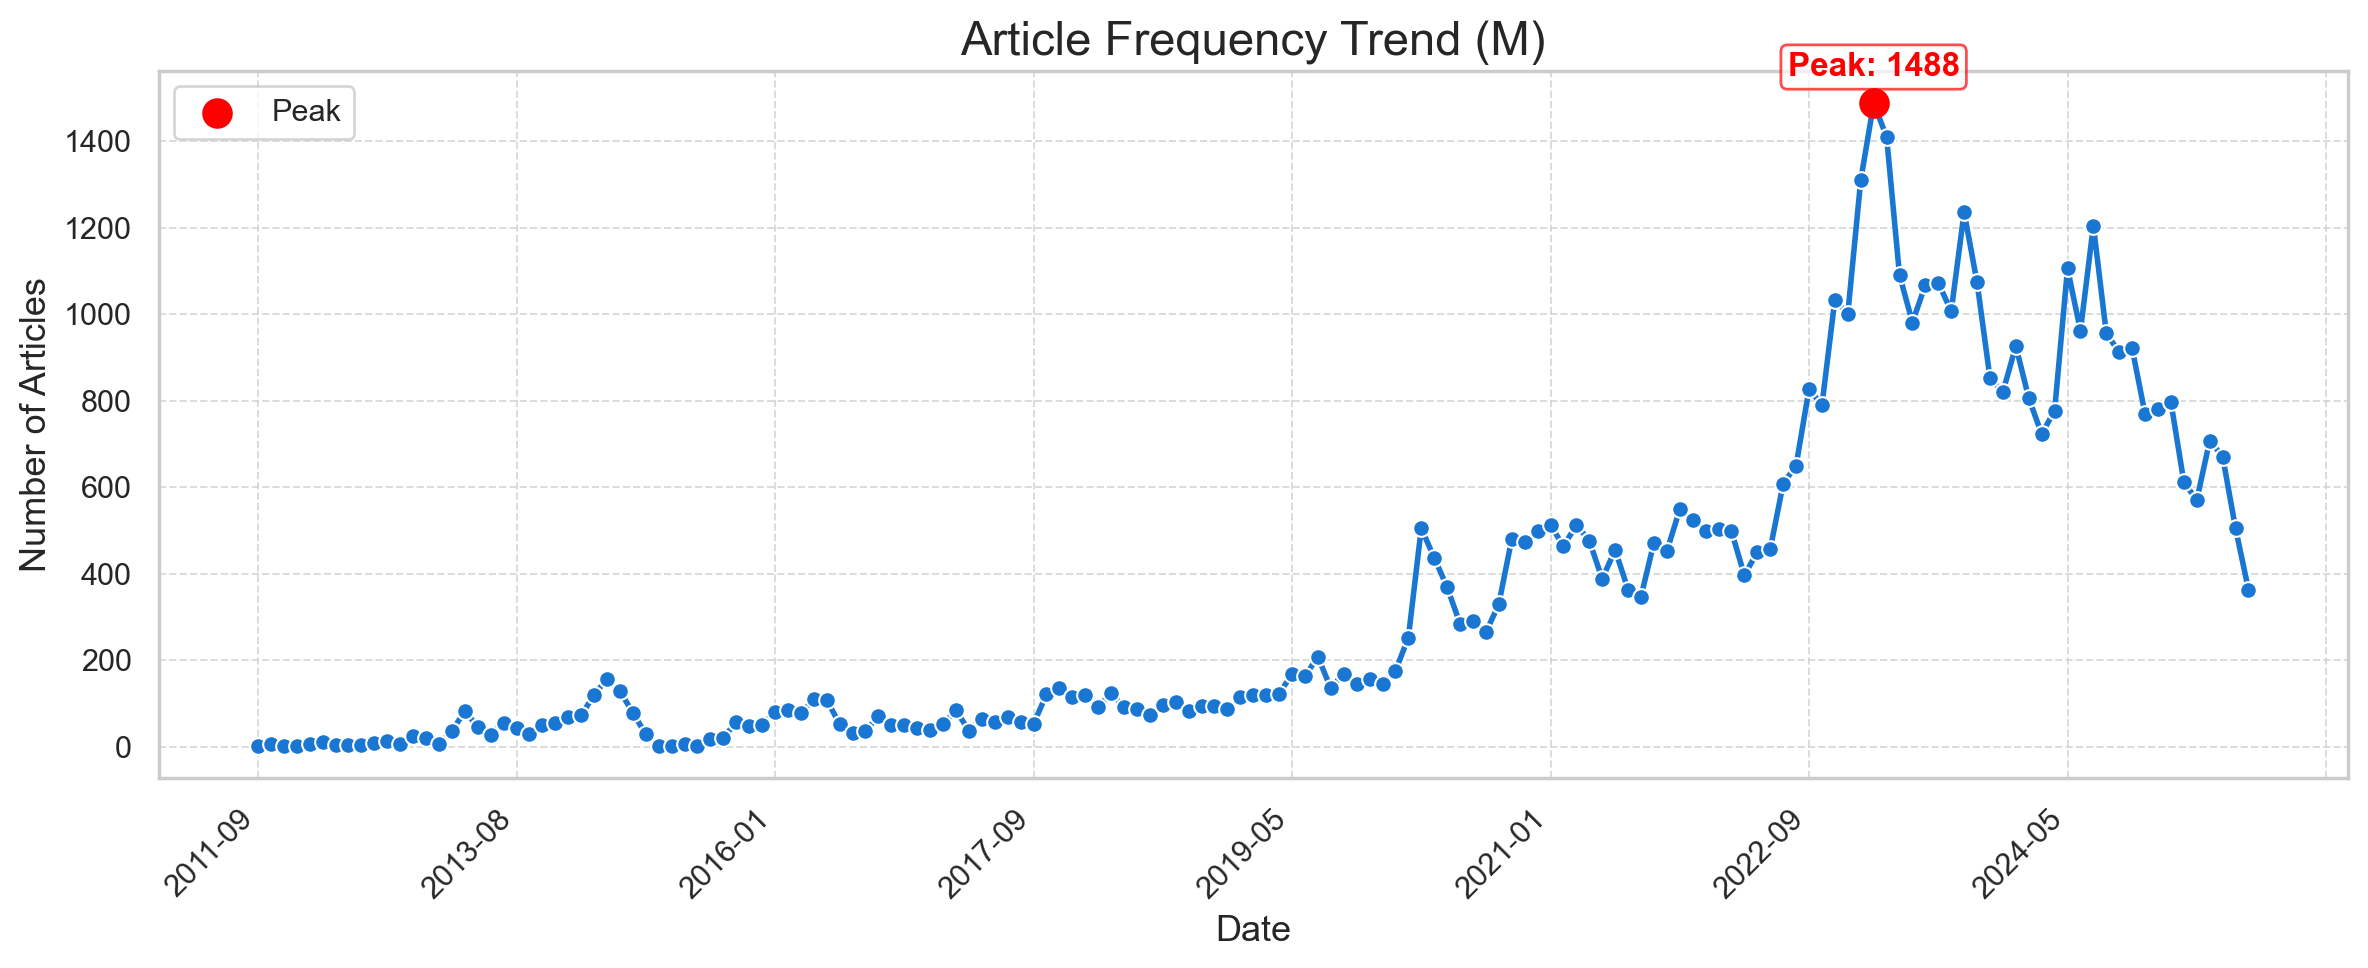

In [58]:
analyzer.plot_trend(freq="M")


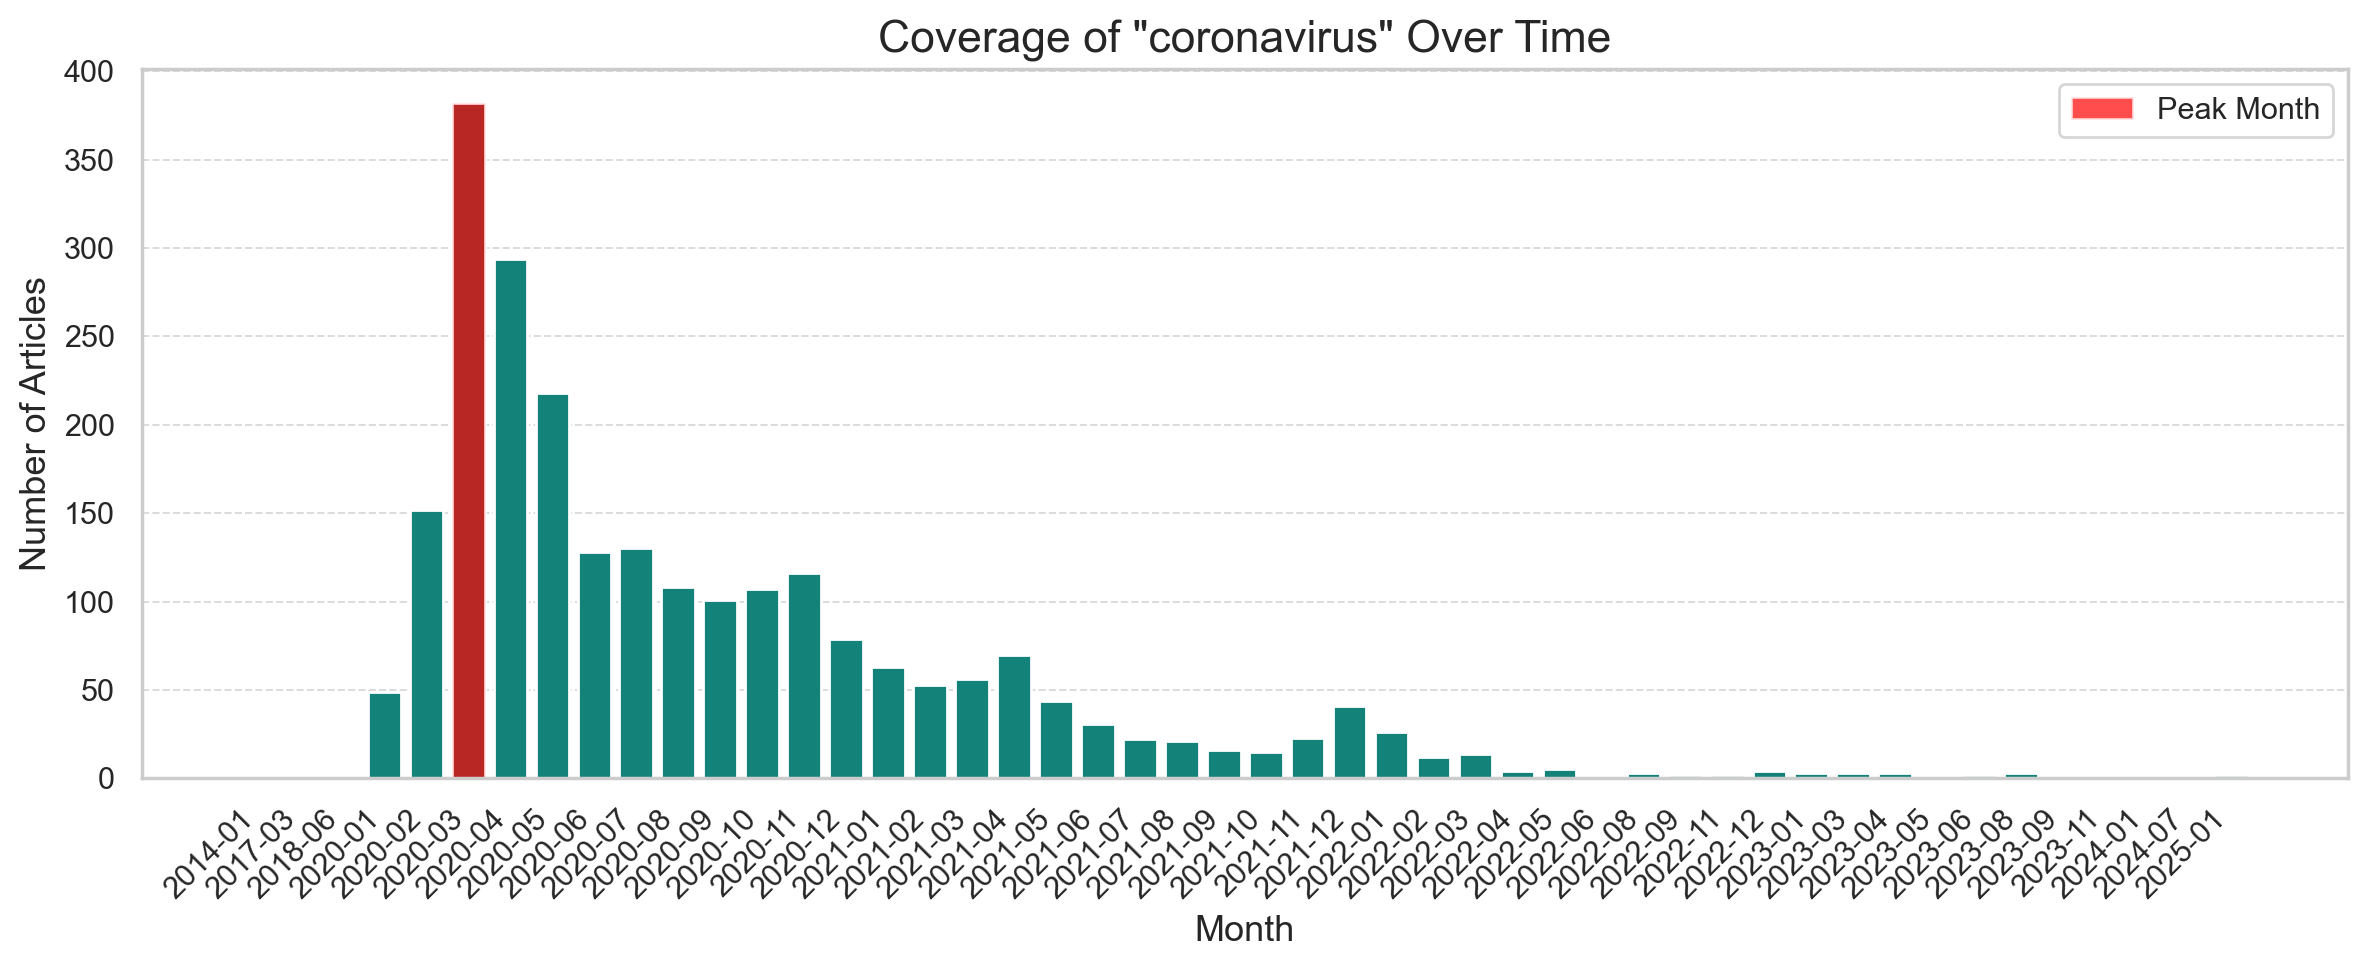

date
2014-01      1
2017-03      1
2018-06      1
2020-01     49
2020-02    152
2020-03    382
2020-04    294
2020-05    218
2020-06    128
2020-07    130
2020-08    108
2020-09    101
2020-10    107
2020-11    116
2020-12     79
2021-01     63
2021-02     53
2021-03     56
2021-04     70
2021-05     44
2021-06     31
2021-07     22
2021-08     21
2021-09     16
2021-10     15
2021-11     23
2021-12     41
2022-01     26
2022-02     12
2022-03     14
2022-04      4
2022-05      5
2022-06      1
2022-08      3
2022-09      2
2022-11      2
2022-12      4
2023-01      3
2023-03      3
2023-04      3
2023-05      1
2023-06      2
2023-08      3
2023-09      1
2023-11      1
2024-01      1
2024-07      1
2025-01      2
Freq: M, Name: Id, dtype: int64

In [59]:
counter = analyzer.get_tag_counts(col="tags_norm")
most_common_tags = [x[0] for x in counter.most_common(5)]
analyzer.plot_tag_coverage_over_time(tag=most_common_tags[4], tags_col="tags_norm")
    

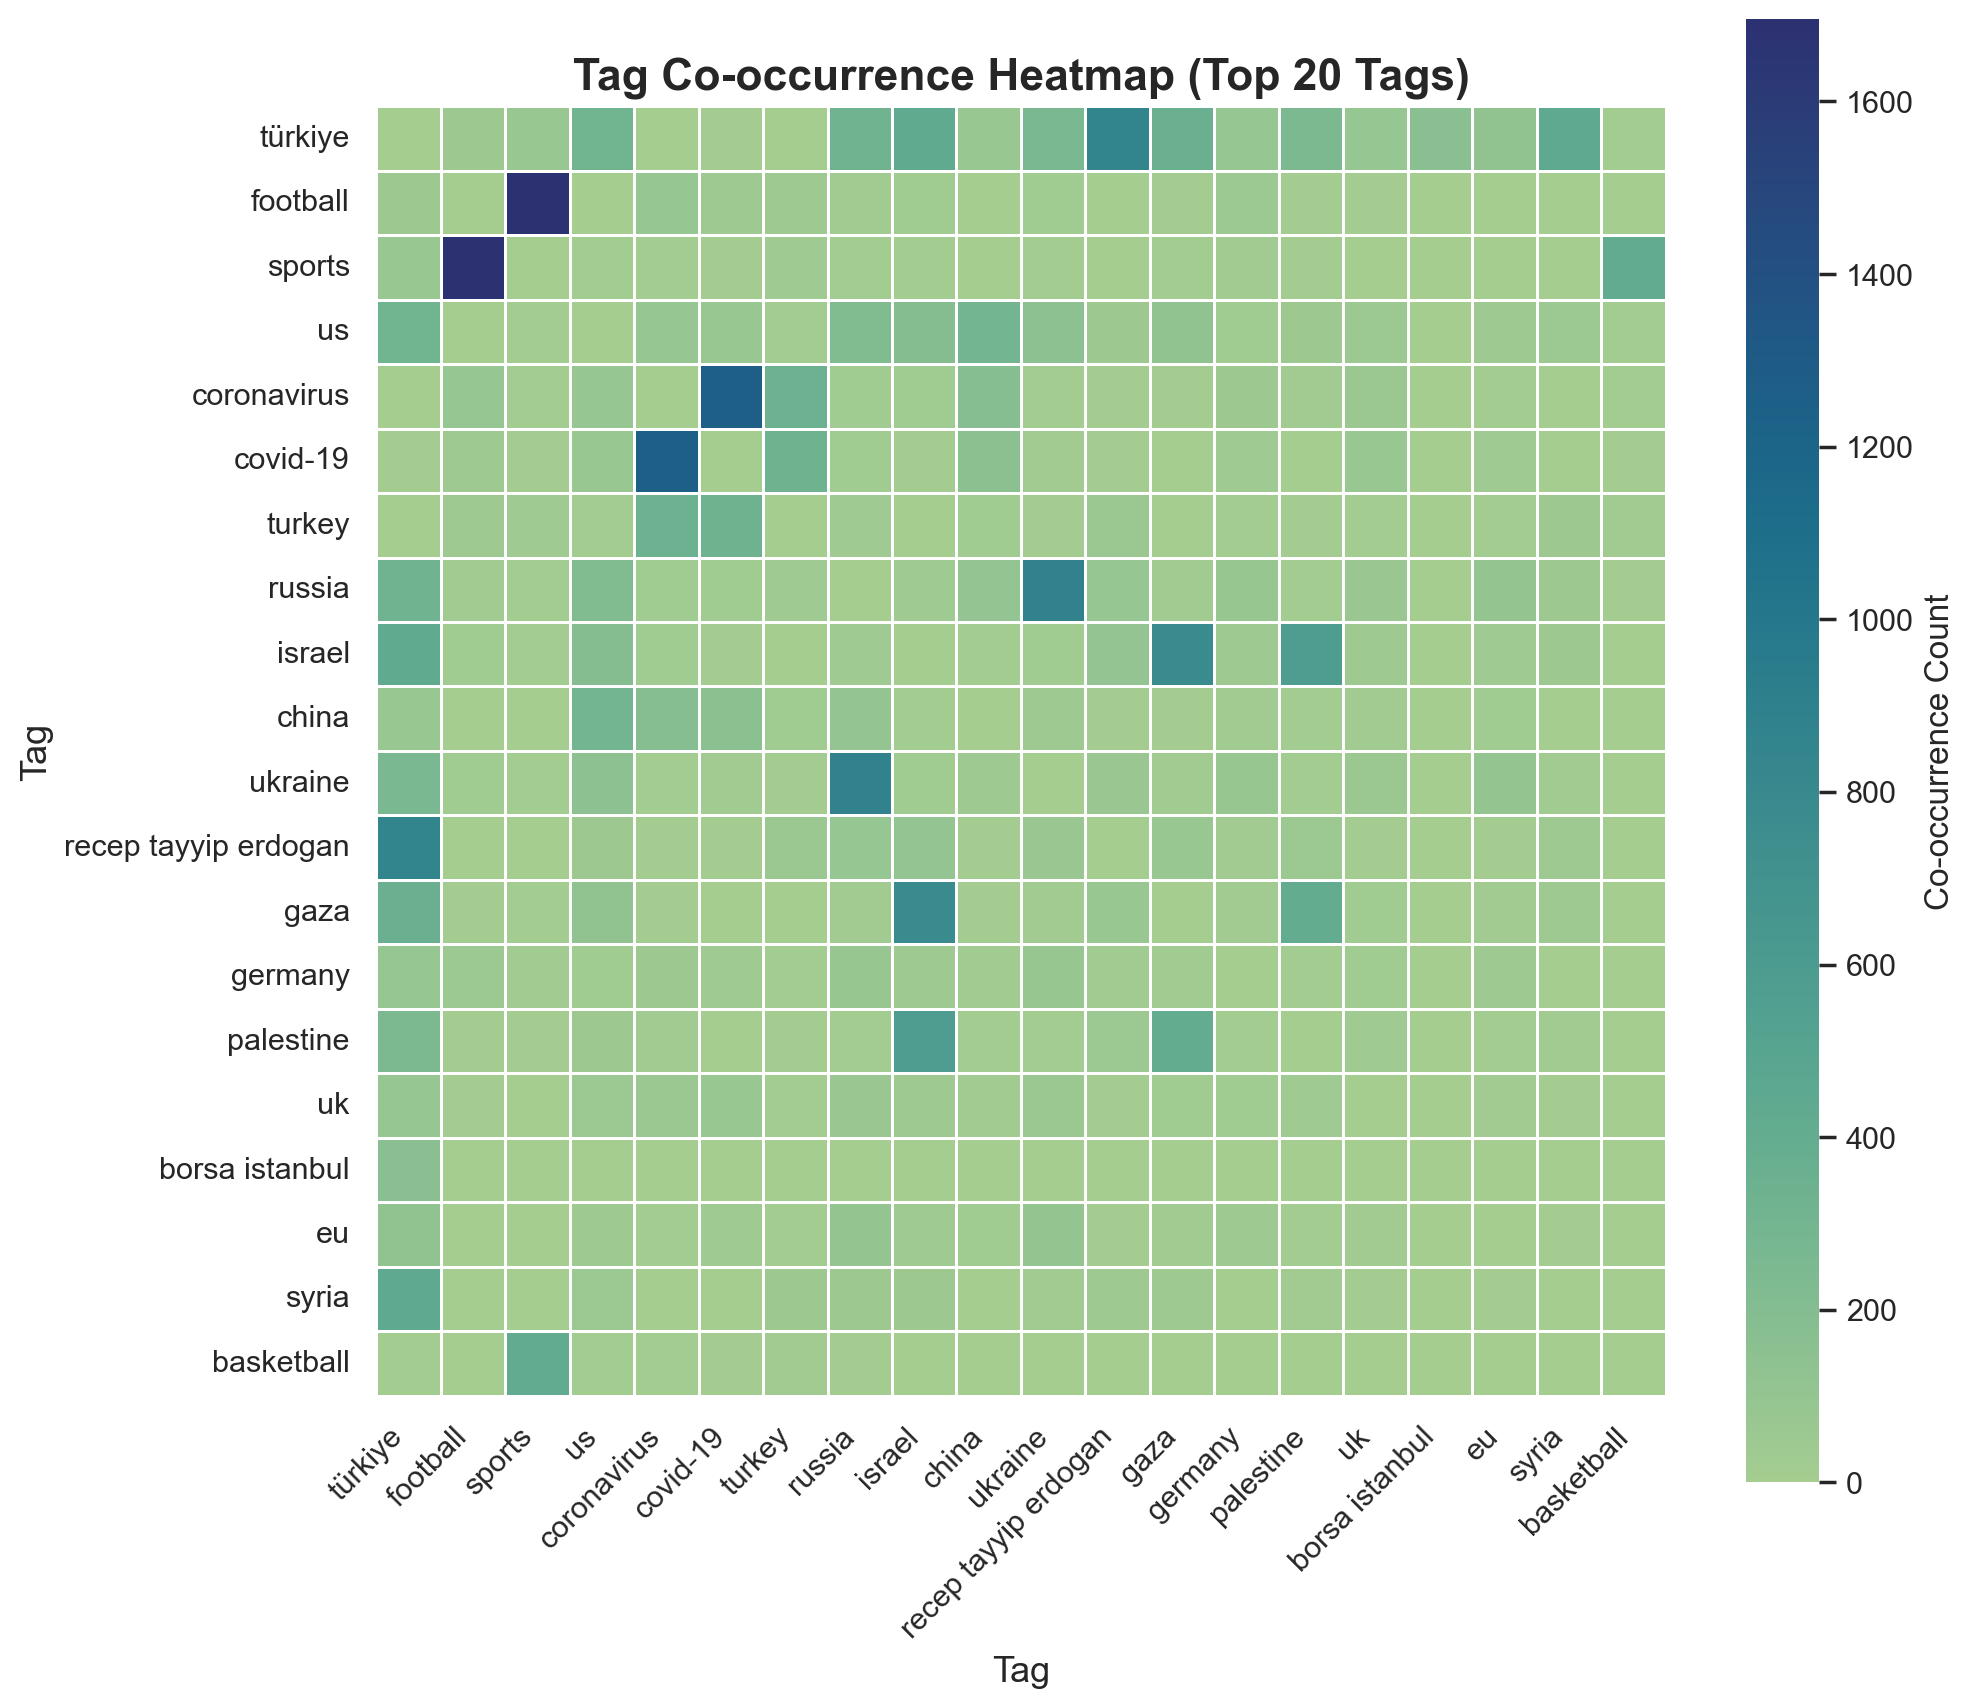

,türkiye,football,sports,us,coronavirus,covid-19,turkey,russia,israel,china,ukraine,recep tayyip erdogan,gaza,germany,palestine,uk,borsa istanbul,eu,syria,basketball
türkiye,0,49,76,316,0,9,2,319,431,74,262,854,358,91,245,88,161,121,443,19
football,49,0,1695,5,89,41,44,21,28,2,29,1,11,53,11,7,0,0,3,2
sports,76,1695,0,17,18,11,34,17,19,3,17,6,14,21,12,3,0,0,2,421
us,316,5,17,0,87,74,19,212,196,299,150,52,122,33,47,57,0,42,57,19
coronavirus,0,89,18,87,0,1258,348,27,32,187,15,7,7,51,20,65,0,17,0,19
covid-19,9,41,11,74,1258,0,333,28,10,153,21,11,3,39,3,73,1,34,1,13
turkey,2,44,34,19,348,333,0,34,5,28,12,65,5,16,10,18,0,14,47,21
russia,319,21,17,212,27,28,34,0,38,112,876,88,20,83,15,70,0,104,51,10
israel,431,28,19,196,32,10,5,38,0,19,30,109,783,43,579,44,0,34,49,4
china,74,2,3,299,187,153,28,112,19,0,46,10,12,26,18,24,0,31,6,0


In [60]:
analyzer.tag_cooccurrence_matrix(tag_col="tags_norm")

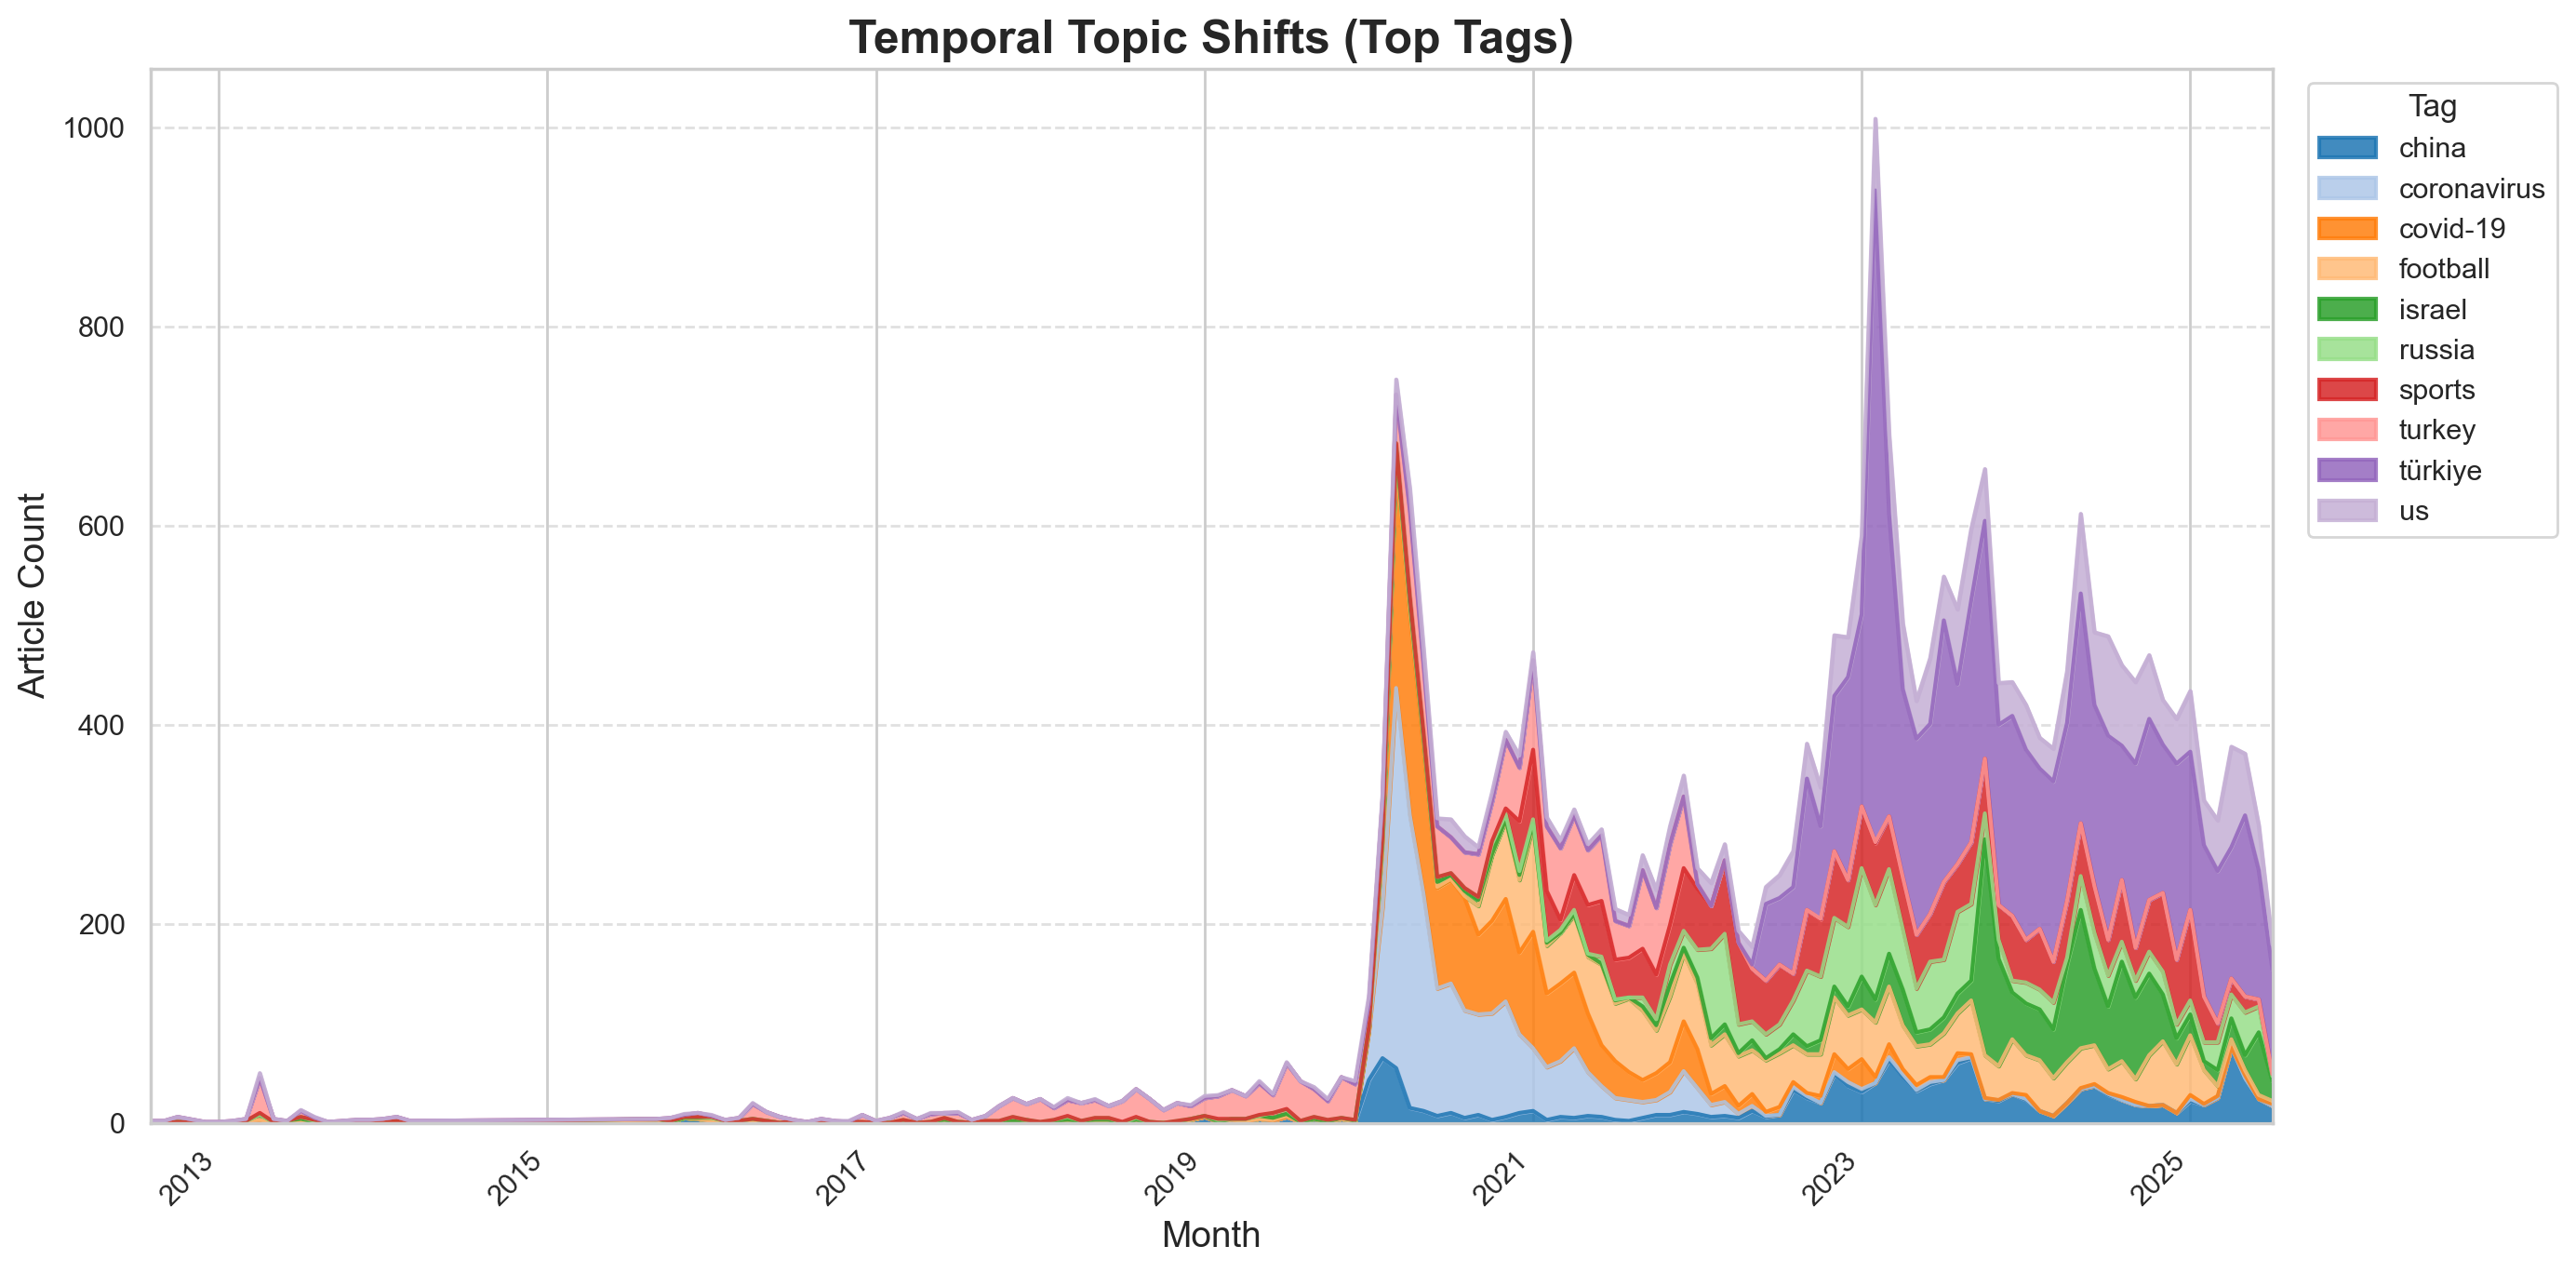

In [61]:
mtx = analyzer.get_tag_month_matrix(tag_col="tags_norm", date_col="date")
Analyzer.plot_tag_temporal_shifts(mtx)

      window  n_emergent                                      emergent_tags  \
147  2024-12         170  [2024, abiy ahmed, abu dhabi, ac milan, ademol...   
148  2025-01         209  [#feature, #uk, - consumer confidence index, 2...   
149  2025-02         125  [aegean sea, afad, ahmad al-sharaa, ahmet yild...   
150  2025-03         144  [a5 defense industry magazine, agriculture‏, a...   
151  2025-04         195  [' recep tayyip erdoğan, 60th presidential cyc...   
152  2025-05         170  [2025, 60th presidential cycling tour of turki...   
153  2025-06          97  [abdulkadir uraloglu, africa, amazon, armenian...   
154  2025-07          72  [2025 fifa club world cup, acquisition, ahmed ...   

     n_decayed                                       decayed_tags  
147        174  [abiy ahmed, abu dhabi, ademola lookman, afad,...  
148        227  [#feature, #uk, - consumer confidence index, 2...  
149        143  [2024, ac milan, aegean sea, afad, africa, ahm...  
150        128  

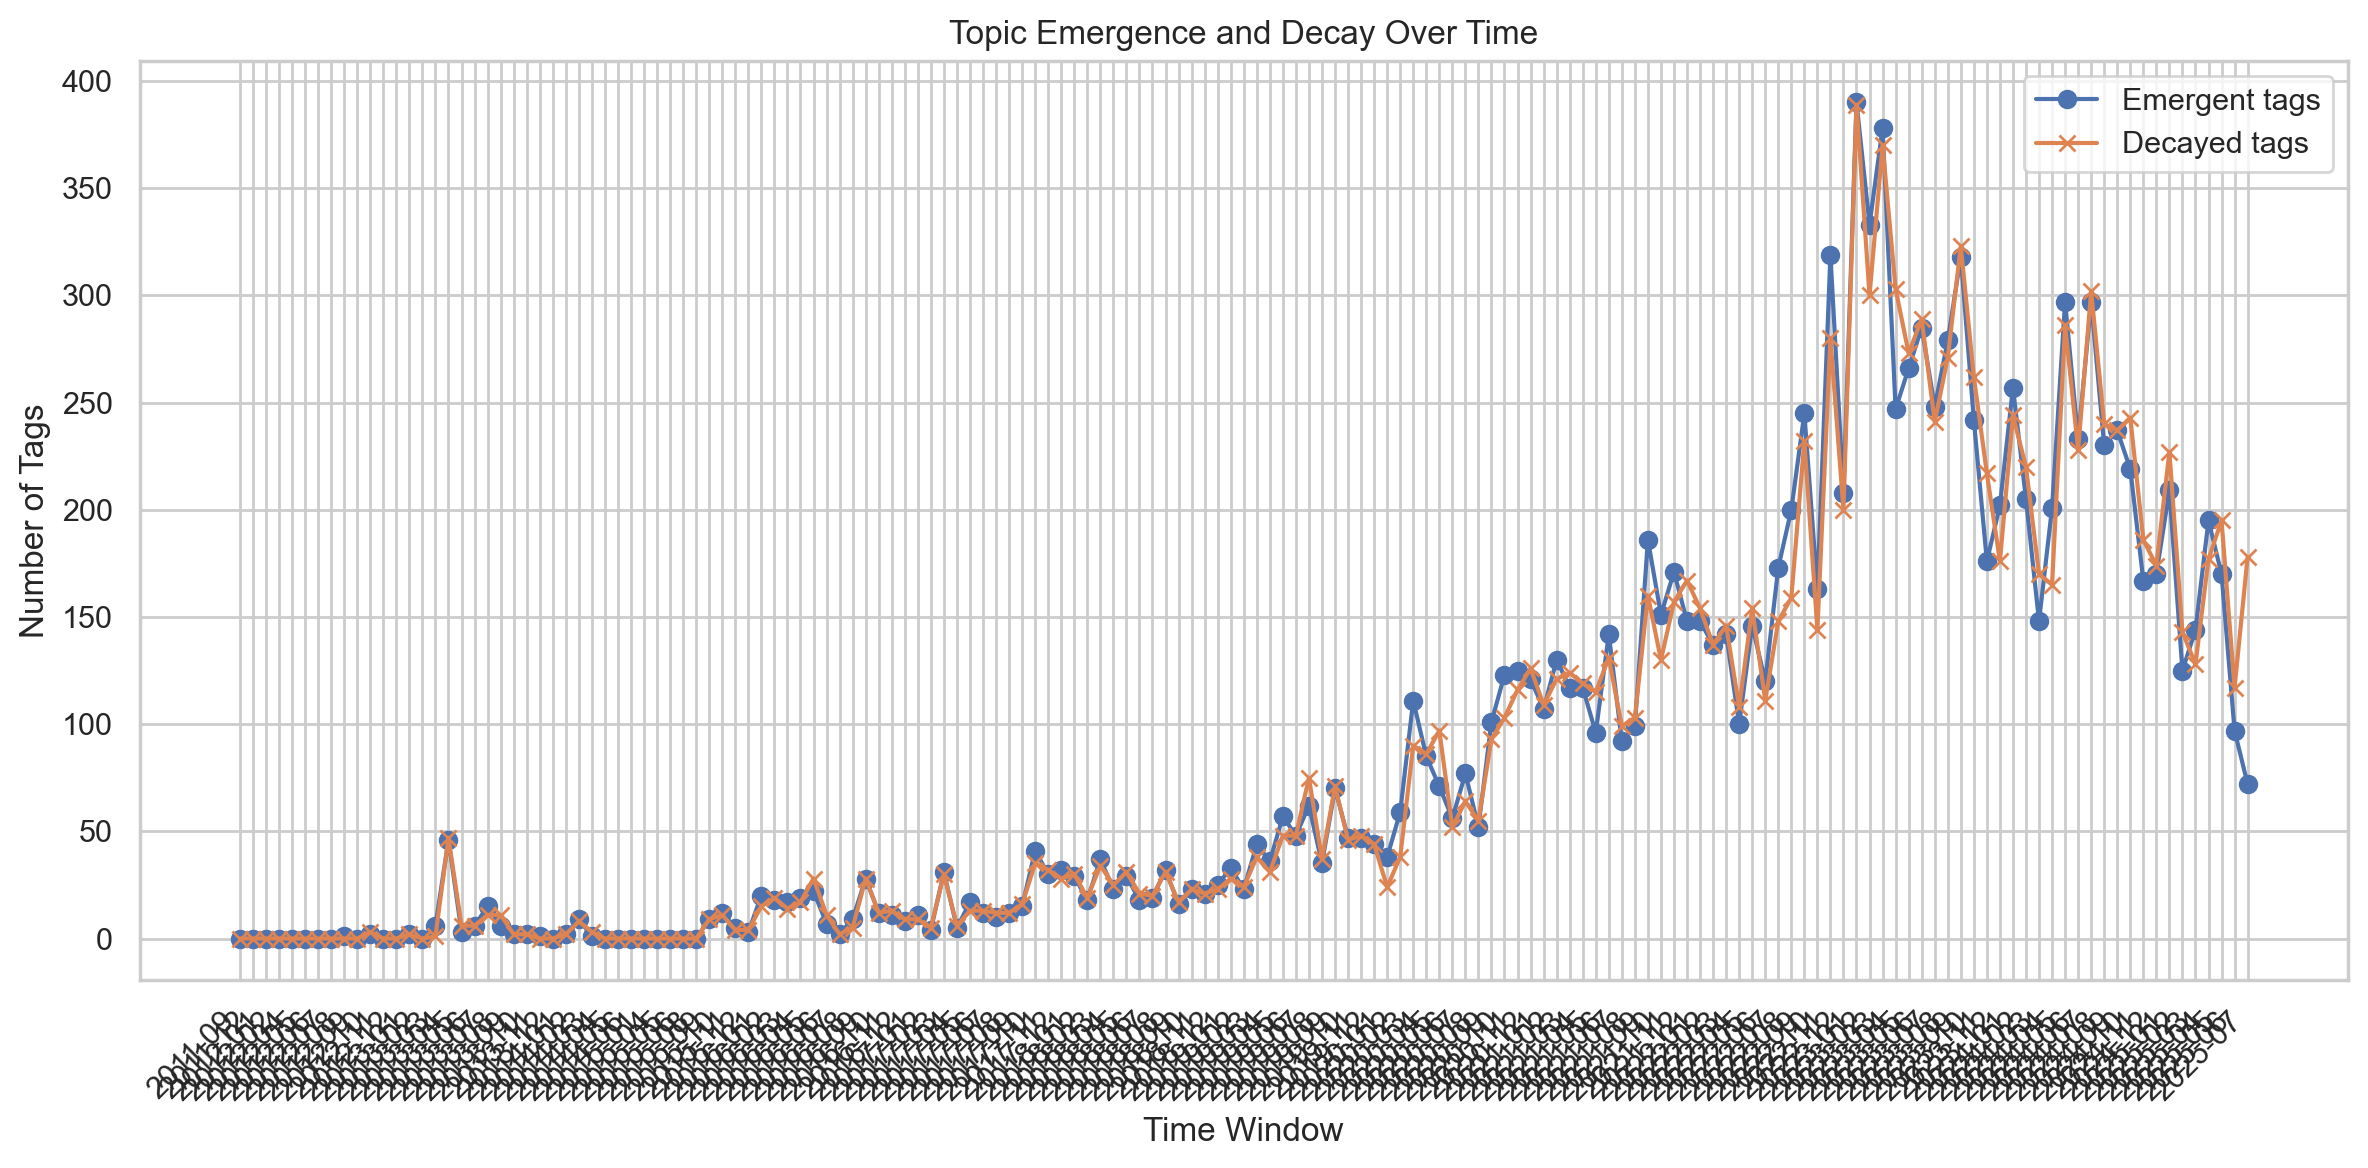


Recent Emergent and Decayed Tags:
 window                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [62]:
emergence_df = analyzer.topic_emergence_decay(
        tag_col="tags_norm", date_col="date", freq="M", min_window_count=2
    )
print(
        emergence_df[
            ["window", "n_emergent", "emergent_tags", "n_decayed", "decayed_tags"]
        ].tail(8)
    )
Analyzer.plot_topic_emergence_decay(emergence_df=emergence_df)

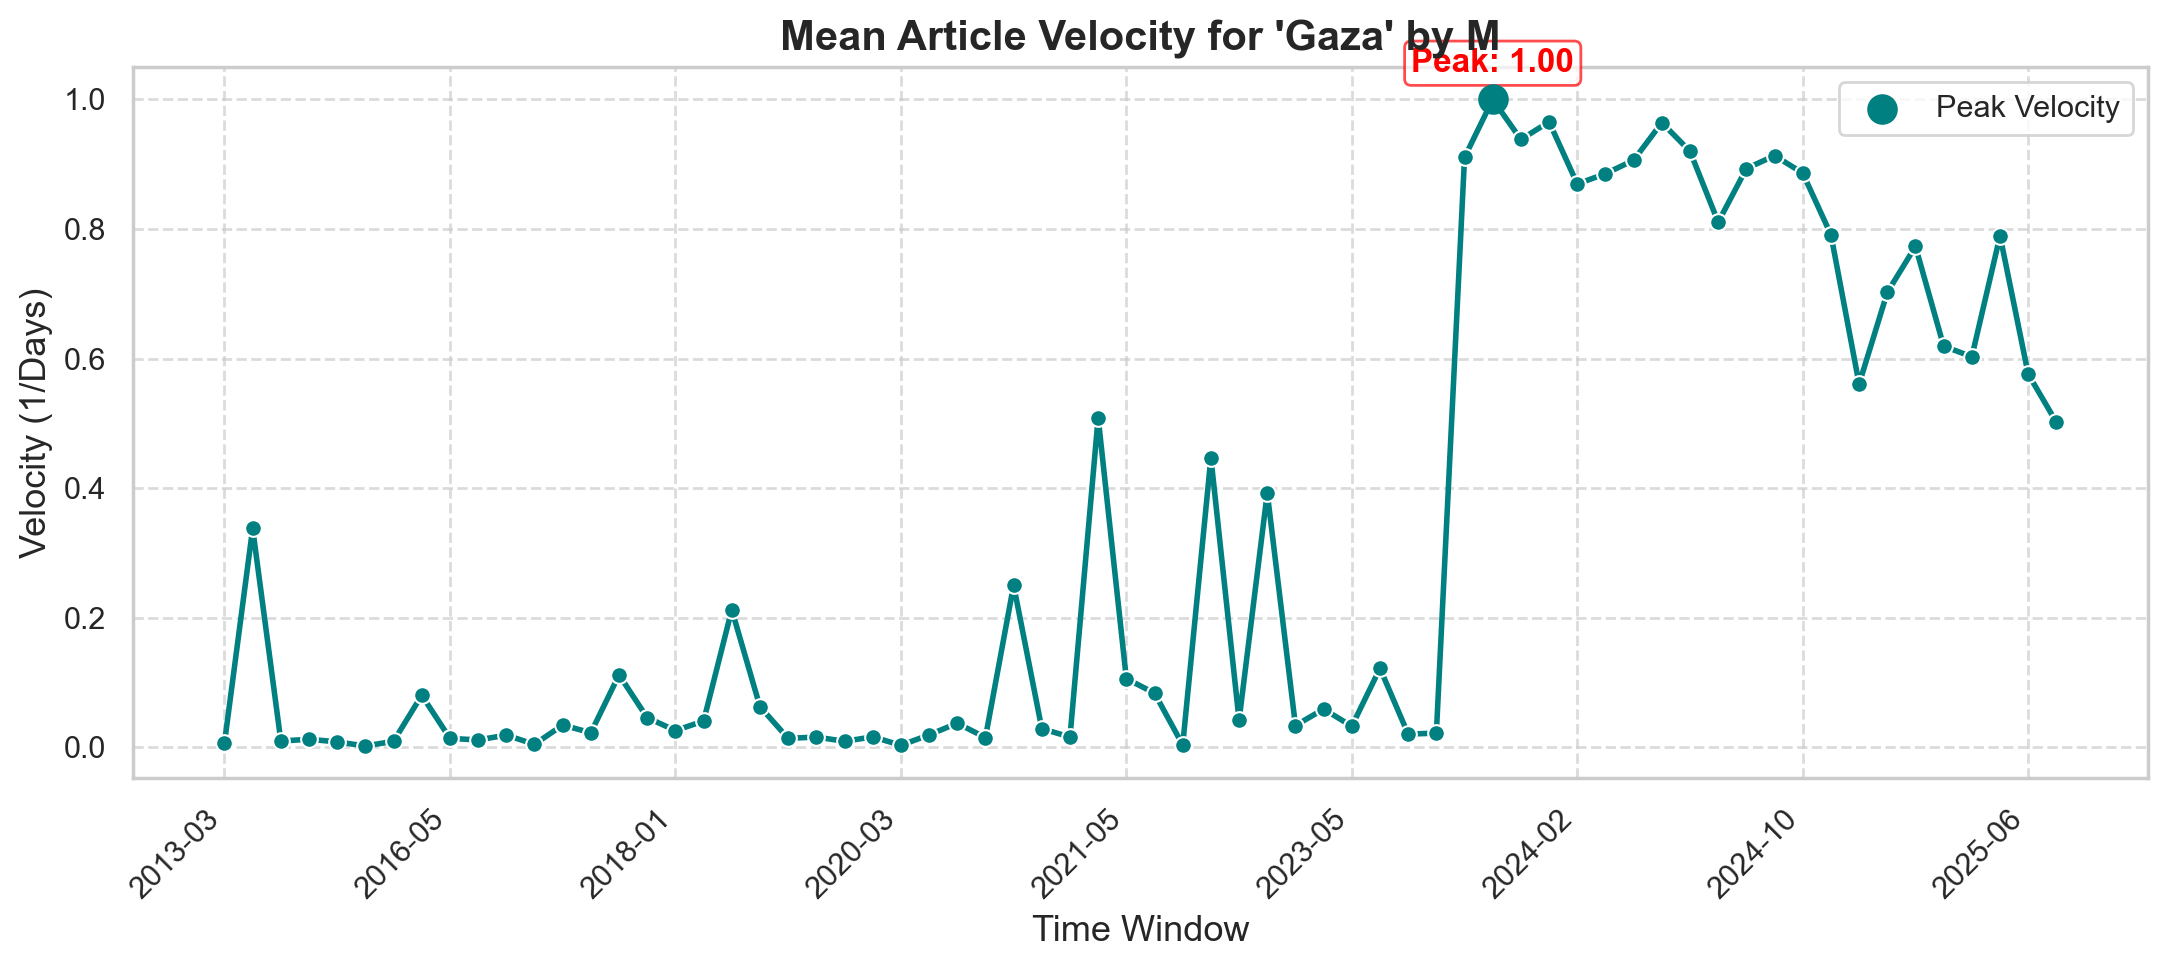

Mean velocity stats:
count    66.000000
mean      0.320268
std       0.371654
min       0.001754
25%       0.016534
50%       0.071275
75%       0.681429
max       1.000000
Name: velocity, dtype: float64


window
2013-03    0.006211
2013-04    0.337623
2013-08    0.009434
2013-10    0.012195
2014-03    0.008065
             ...   
2025-03    0.619048
2025-04    0.602869
2025-05    0.789474
2025-06    0.575952
2025-07    0.501587
Freq: M, Name: velocity, Length: 66, dtype: float64

In [63]:
analyzer.plot_article_velocity_agg(
        "Gaza", tag_col="tags_norm", date_col="date", time_unit="days", freq="M"
    )

Event/tag: 'Gaza'
First appearance: 2012-10-12
Peak window: 2023-11 with 142 articles
Last appearance: 2025-07-21
Lifespan: 4665 days (666 weeks)
Total articles: 1269


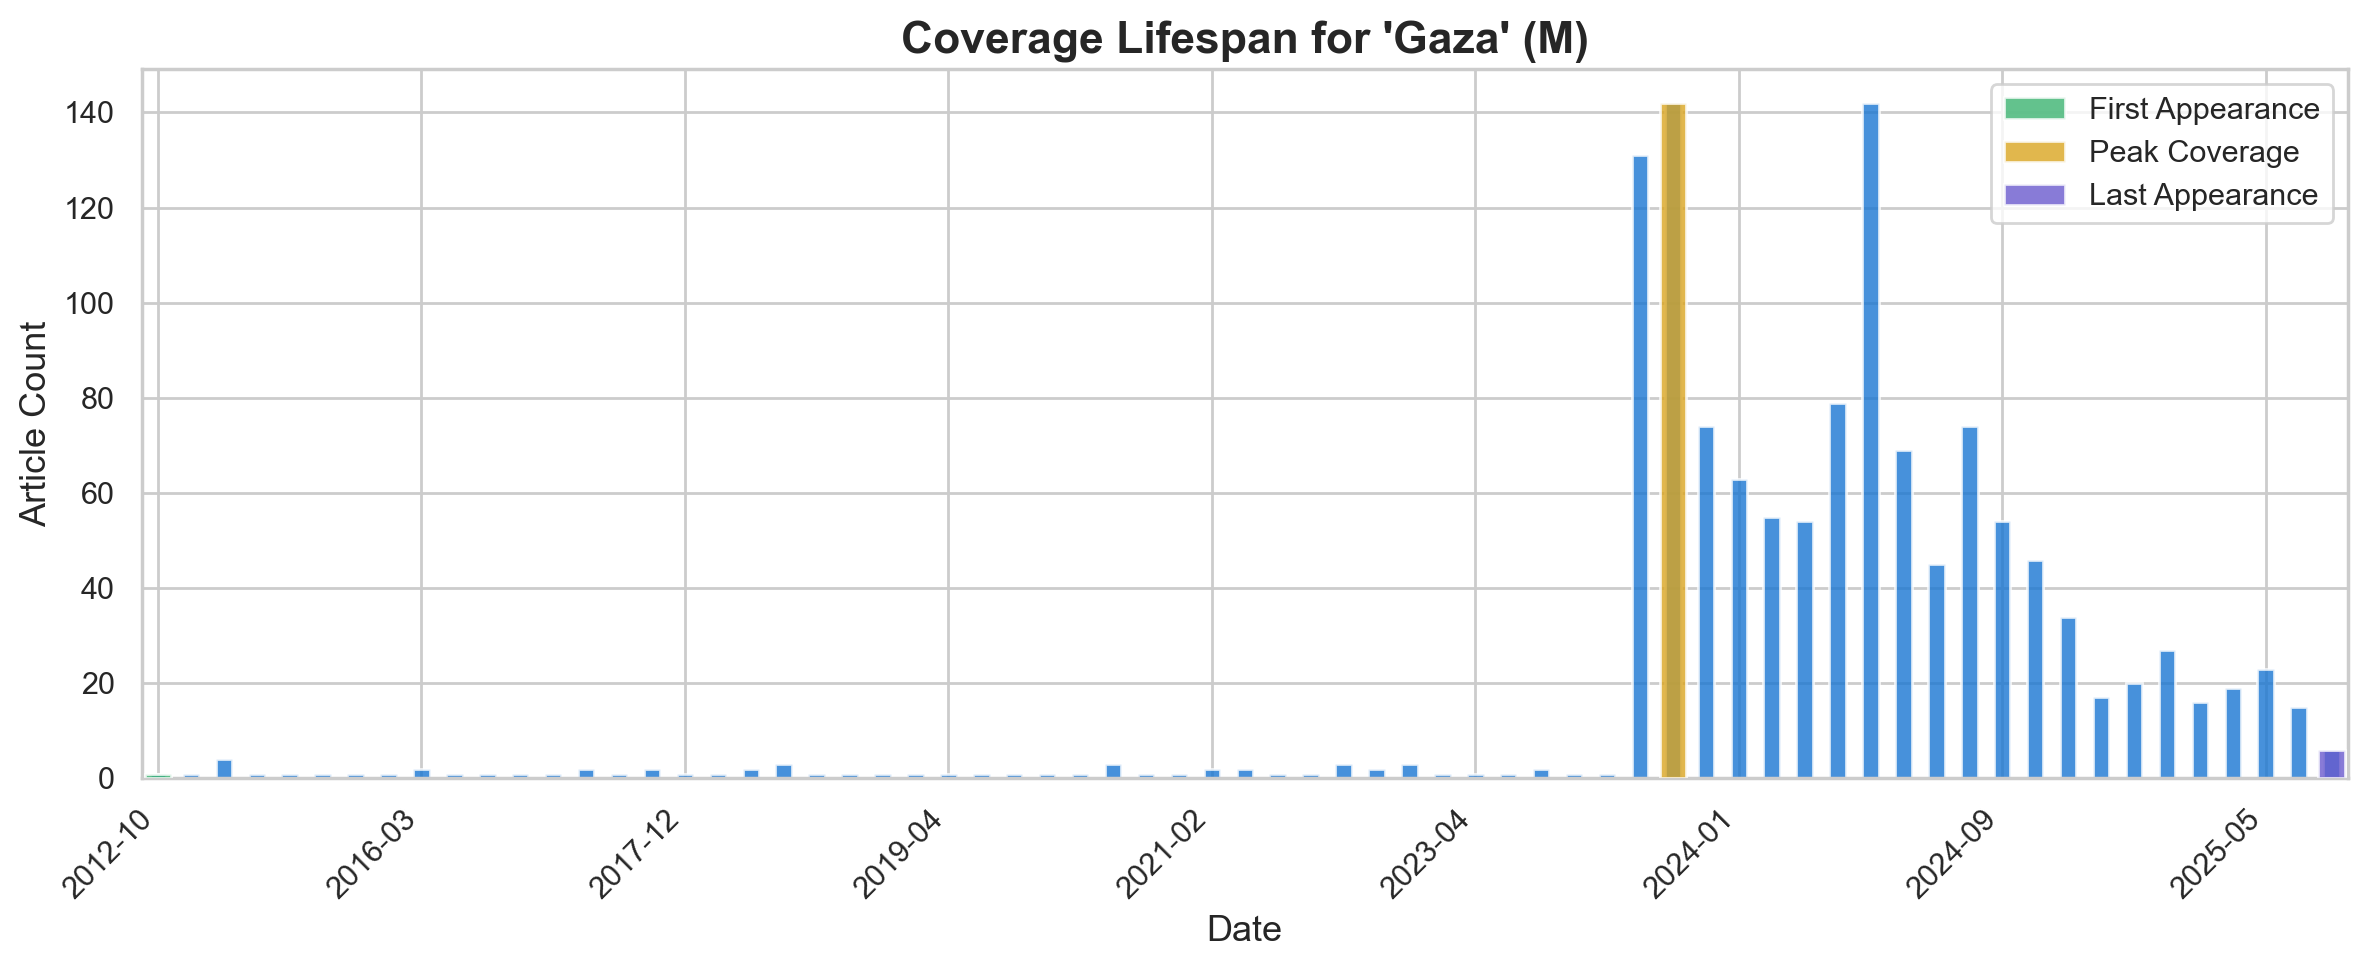

In [64]:
grouped, first, peak, last = analyzer.event_coverage_lifespan(
        "Gaza", tag_col="tags_norm", date_col="date", freq="M"
    )
if grouped is not None:
        Analyzer.plot_event_lifespan(grouped, first, peak, last, freq="M", tag="Gaza")
    